In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
quasJ = os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783J/')
quasJ = [os.path.join('/../home/lynge/MasterP/NGC3783/NGC3783J',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783J/')]

qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

MAG_HD101274_B = 9.23
MAG_HD101274_V = 9.12
MAG_HD101274_G = 9.192
MAG_HD101274_J = float('nan')
MAG_HD101274_H = float('nan')
MAG_HD101274_K = float('nan')

MAG_TYCHO_2_7740_22_1_B = 12.58
MAG_TYCHO_2_7740_22_1_V = 12.12
MAG_TYCHO_2_7740_22_1_G = 11.78
MAG_TYCHO_2_7740_22_1_J = 10.919
MAG_TYCHO_2_7740_22_1_H = 10.726
MAG_TYCHO_2_7740_22_1_K = 10.611

MAG_TYCHO_2_7740_529_1_B = 11.61
MAG_TYCHO_2_7740_529_1_V = 10.94
MAG_TYCHO_2_7740_529_1_G = 10.867
MAG_TYCHO_2_7740_529_1_J = 9.902
MAG_TYCHO_2_7740_529_1_H = 9.625
MAG_TYCHO_2_7740_529_1_K = 9.580

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

In [3]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [4]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [5]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [6]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    try:
        mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
        AGNdata[mask] = float(0)
        mask = AGNdata == 0.
        rows = np.flatnonzero((~mask).sum(axis=1))
        cols = np.flatnonzero((~mask).sum(axis=0))
        AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
        #print apparature/float(pixspa)
    except:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [7]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [8]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":20, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':100, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [9]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    output = float('nan') 
    out = SXtable(quas,aperture)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
    #print RAmain, DECmain
    header = pyfits.getheader(quas)
    for j in range(len(out['table']['XMODEL_IMAGE'])):
        #output['time'][i] = header['MJD-OBS']
        if RAmain - 5. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 5. and \
        DECmain - 5. < out['table']['YMODEL_IMAGE'][j] < DECmain + 5.:
            print 'YES'
            output = out['table']['FLUX_APER'][j]
            break
    print 'Done'
    return output


In [10]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = data2
    
    return float(header['GAIN'])*data1_2*header['DIT']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['DIT'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['DIT']
                                                         +(header['NDIT']*npix1*header['RON']/
                                                           float(header['GAIN']))**2))
#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

In [11]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.001
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),7))
    SNR_array = np.zeros((len(quas),8))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(2*aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(2*aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(2*aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(2*aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = np.sum(a_AGN)/float(np.count_nonzero(a_AGN)) - a_sky_2 #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix - a_sky_2
        a3_3 = a3/a3_pix - a_sky_2
        a4_3 = a4/a4_pix - a_sky_2
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN,a2))
        flucompsta2.append(comp1(a_AGN,a3))
        flucompsta3.append(comp1(a_AGN,a4))
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        #comp_array[i,4] = flucompsta4[i]
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
    print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    ABS_FLUX_V_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date

In [12]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.0015)

Frame nr.  0


No handlers could be found for logger "sewpy.sewpy"
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


YES
Done
YES
Done
YES
Done
Done
1916.635
Frame nr.  1
YES
Done
YES
Done
YES
Done
YES
Done
3267.505
Frame nr.  2
YES
Done
Done
YES
Done
Done
2769.515
Frame nr.  3
YES
Done
YES
Done
YES
Done
YES
Done
2100.902
Frame nr.  4
YES
Done
YES
Done
Done
YES
Done
2237.493
Frame nr.  5
YES
Done
YES
Done
YES
Done
YES
Done
2301.472
Frame nr.  6
YES
Done
Done
YES
Done
YES
Done
1649.281
Frame nr.  7
YES
Done
YES
Done
YES
Done
Done
2231.492
Frame nr.  8
YES
Done
YES
Done
YES
Done
Done
2075.241
Frame nr.  9
YES
Done
Done
Done
Done
2504.576
Frame nr.  10
YES
Done
YES
Done
YES
Done
YES
Done
513.3116
Frame nr.  11
YES
Done
YES
Done
Done
Done
2215.611
Frame nr.  12
YES
Done
YES
Done
YES
Done
YES
Done
1266.835
Frame nr.  13
YES
Done
YES
Done
YES
Done
Done
2217.149
Frame nr.  14
YES
Done
YES
Done
YES
Done
Done
2027.077
Frame nr.  15
YES
Done
YES
Done
YES
Done
YES
Done
2011.054
Frame nr.  16
YES
Done
YES
Done
Done
Done
2318.078
Frame nr.  17
YES
Done
YES
Done
Done
Done
2292.229
Frame nr.  18
YES
Done
YES
Done
Y

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Done
Done
YES
Done
Done
nan
Frame nr.  21
YES
Done
YES
Done
YES
Done
Done
2333.26
Frame nr.  22
YES
Done
Done
YES
Done
YES
Done
3062.159
Frame nr.  23
YES
Done
YES
Done
YES
Done
Done
2100.807
Frame nr.  24
YES
Done
YES
Done
YES
Done
Done
2080.054
Frame nr.  25
YES
Done
YES
Done
YES
Done
Done
2265.259
Frame nr.  26
YES
Done
YES
Done
Done
Done
2338.965
Frame nr.  27
YES
Done
YES
Done
YES
Done
Done
4483.848
Frame nr.  28
YES
Done
YES
Done
YES
Done
Done
1839.706
Frame nr.  29
YES
Done
YES
Done
YES
Done
Done
2894.908
Frame nr.  30
YES
Done
YES
Done
Done
Done
914.2896
Frame nr.  31
YES
Done
YES
Done
Done
YES
Done
2183.433
Frame nr.  32
YES
Done
YES
Done
Done
Done
2416.219
Frame nr.  33
YES
Done
YES
Done
YES
Done
Done
955.7308
Frame nr.  34
YES
Done
Done
YES
Done
Done
2881.088
Frame nr.  35
YES
Done
YES
Done
YES
Done
Done
3018.839
Frame nr.  36
YES
Done
Done
YES
Done
Done
2469.619
Frame nr.  37
YES
Done
YES
Done
Done
Done
3057.813
YES


In [13]:
def AGNflux(quas,aperture1):
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    SNR1 = []
    SNR2 = []
    SNR3 = []
    SNR4 = []
    SNR5 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    for i in range(len(quas)):
        #print 'Frame nr. ', i
        header = pyfits.getheader(quas[i])
        a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a5 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (gal_RA_WORLD,gal_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        date.append(header['MJD-OBS'])
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2,cmap='hot')
        #plt.show()
        #print 'AGN3783', a1, np.sum(a2)
        #print 'SKY', a_sky, np.sum(a_sky)
        flucompsta1.append(comp1(np.sum(a1),np.sum(a2)))
        flucompsta2.append(comp1(np.sum(a1),np.sum(a3)))
        flucompsta3.append(comp1(np.sum(a3),np.sum(a2)))
        flucompsta4.append(comp1(np.sum(a1),np.sum(a4)))
        flucompsta5.append(comp1(np.sum(a1),np.sum(a5)))
        flucompsta6.append(comp1(np.sum(a4),np.sum(a2)))
        flucompsta7.append(comp1(np.sum(a5),np.sum(a2)))
        SNR1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture1,aperture1))
        SNR2.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture1,aperture1))
        SNR3.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture1,aperture1))
        SNR4.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture1,aperture1))
        SNR5.append(SNR(np.sum(a5),np.sum(a_sky),header,aperture1,aperture1))
        poissonAGN.append(np.sqrt(np.sum(a1)*header['DIT']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['DIT']))
        poisson22.append(np.sqrt(np.sum(a3)*header['DIT']))
        poisson529.append(np.sqrt(np.sum(a4)*header['DIT']))
        #print header['EXPTIME']
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_J,\
                                                            MAG_VEGA_J,FLUX_LAMBDA_VEGA_J)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    ABS_FLUX_V_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_J,\
                                                            MAG_VEGA_J,FLUX_V_VEGA_J)
    return np.array(flucompsta1),np.array(flucompsta2),np.array(flucompsta3),np.array(flucompsta4),\
np.array(flucompsta5),np.array(flucompsta6),np.array(flucompsta7),np.array(SNR1),np.array(SNR2),np.array(SNR3),\
np.array(SNR4),np.array(SNR5),np.array(SNR_comp),ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529

In [14]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529 = AGNflux(quasJ,0.003)

/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in sqrt


In [15]:
print np.shape(ABS_FLUX_V_3_1), np.shape(date_1)


(0,) (38,)


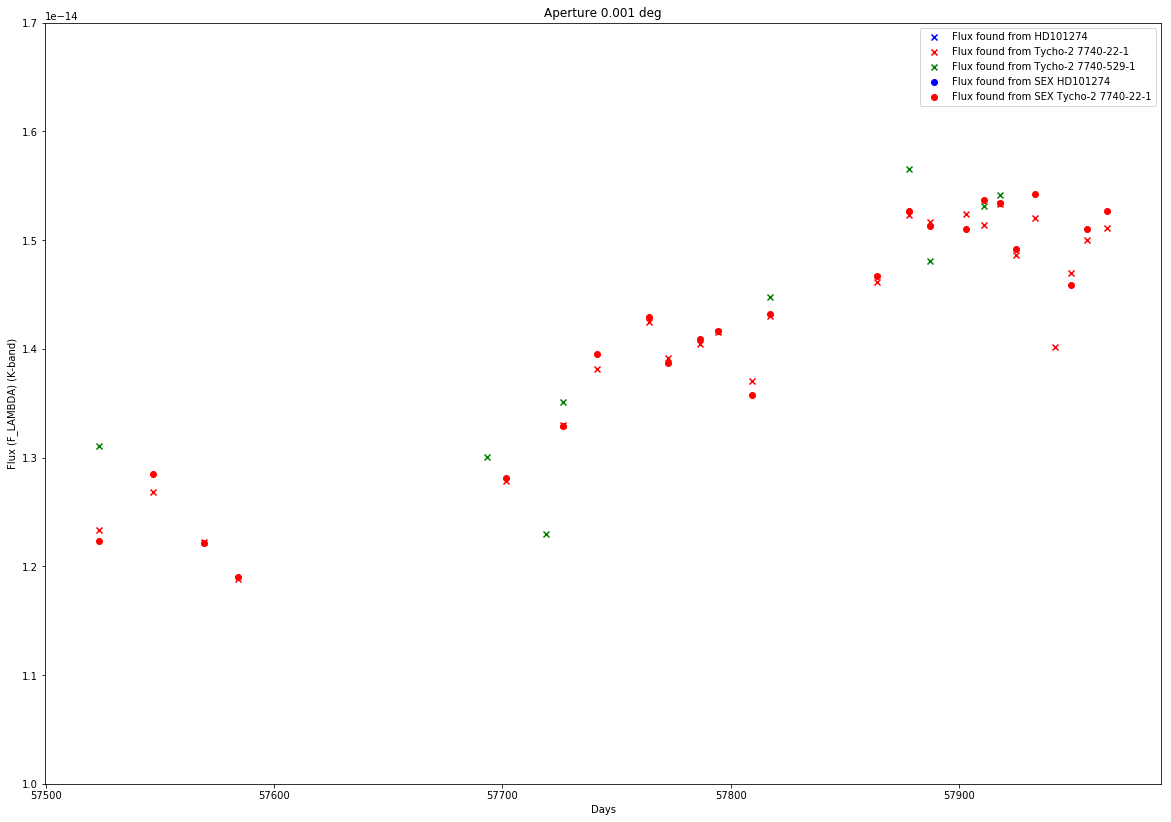

In [16]:
plt.figure(figsize=(20,14))
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([1*10**(-14),1.7*10**(-14)])
plt.legend()
plt.show()


In [17]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.0005)

Frame nr.  0
YES
Done
YES
Done
YES
Done
Done
956.122
Frame nr.  1
YES
Done
YES
Done
YES
Done
YES
Done
1699.591
Frame nr.  2
YES
Done
Done
YES
Done
Done
843.9898
Frame nr.  3
YES
Done
YES
Done
YES
Done
YES
Done
921.2969
Frame nr.  4
YES
Done
YES
Done
Done
YES
Done
993.6229
Frame nr.  5
YES
Done
YES
Done
YES
Done
YES
Done
1060.277
Frame nr.  6
YES
Done
Done
YES
Done
YES
Done
668.3074
Frame nr.  7
YES
Done
YES
Done
YES
Done
Done
1073.357
Frame nr.  8
YES
Done
YES
Done
YES
Done
Done
846.9965
Frame nr.  9
YES
Done
Done
Done
Done
1113.248
Frame nr.  10
YES
Done
YES
Done
YES
Done
YES
Done
244.6771
Frame nr.  11
YES
Done
YES
Done
Done
Done
1059.552
Frame nr.  12
YES
Done
YES
Done
YES
Done
YES
Done
597.2581
Frame nr.  13
YES
Done
YES
Done
YES
Done
Done
972.1603
Frame nr.  14
YES
Done
YES
Done
YES
Done
Done
868.1698
Frame nr.  15
YES
Done
YES
Done
YES
Done
YES
Done
996.0172
Frame nr.  16
YES
Done
YES
Done
Done
Done
1060.233
Frame nr.  17
YES
Done
YES
Done
Done
Done
1005.872
Frame nr.  18
YES
Don

In [18]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529 = AGNflux(quasJ,0.001)

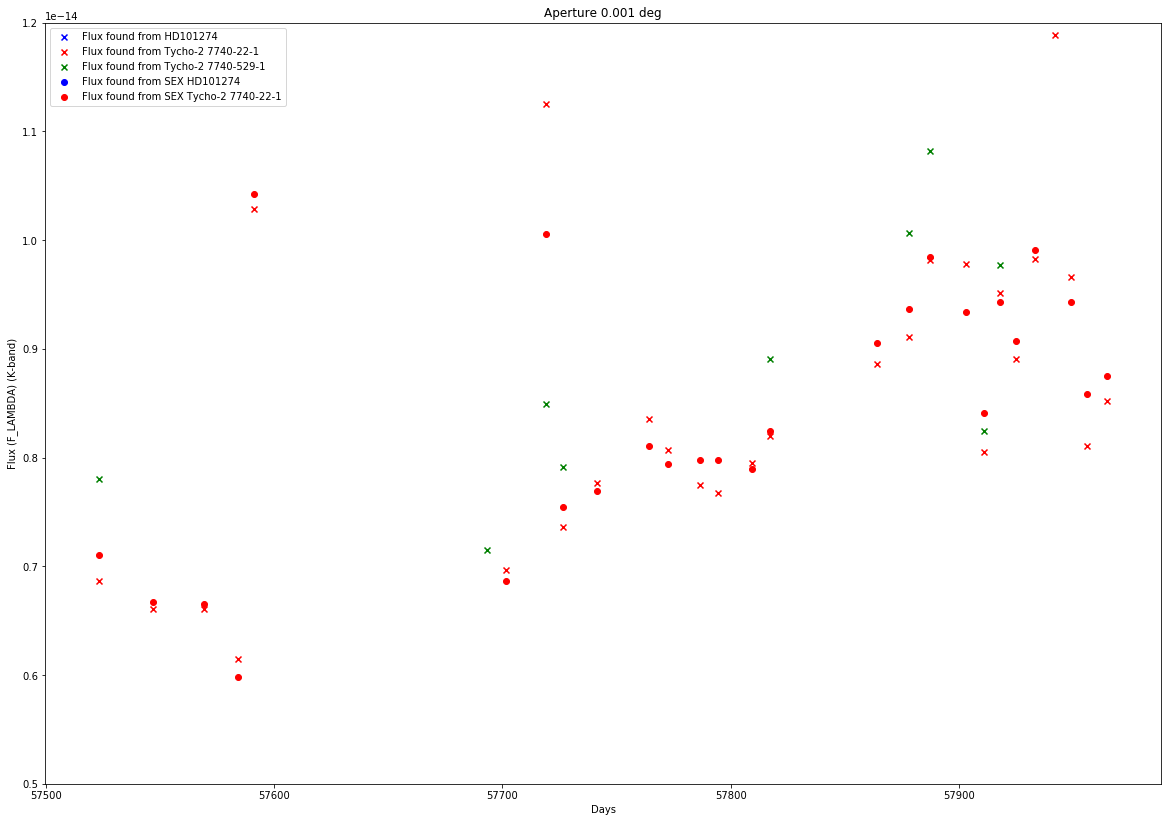

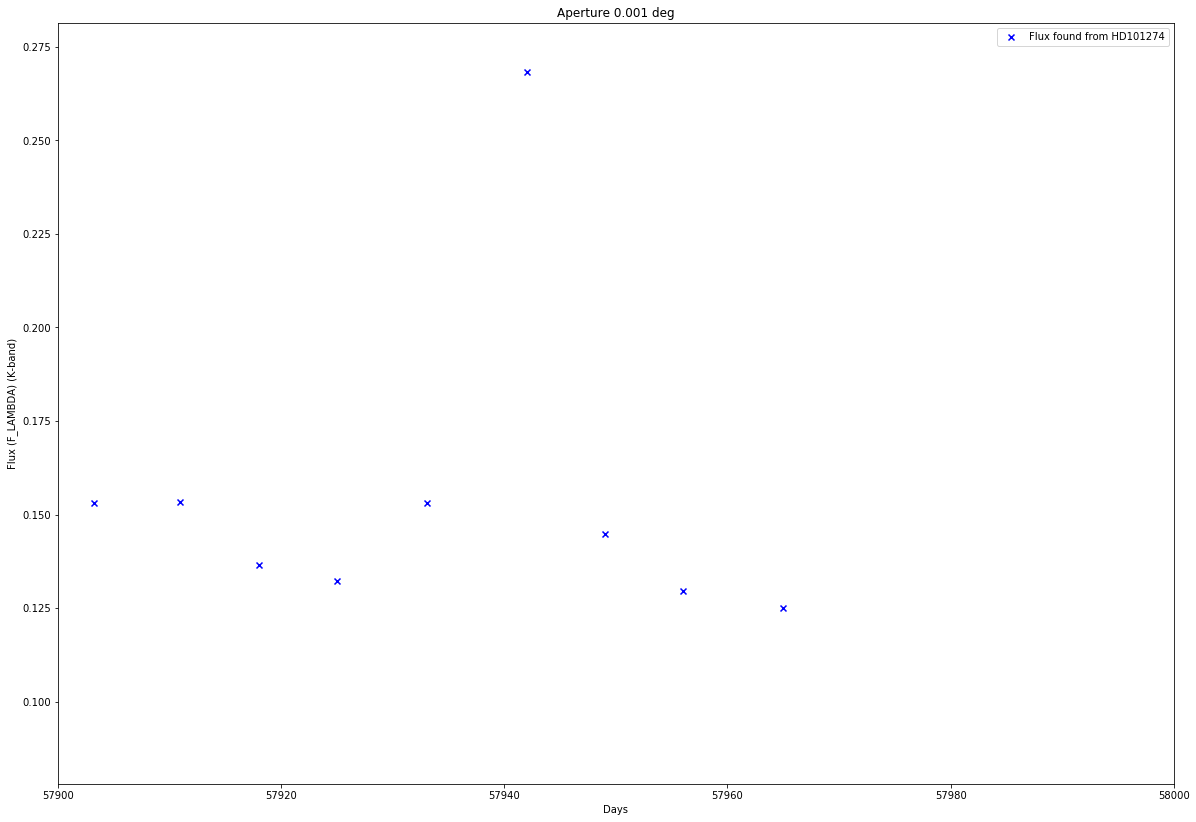

In [37]:
plt.figure(figsize=(20,14))
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.5*10**(-14),0.12*10**(-13)])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(flucompsta1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
plt.xlim([57900,58000])
plt.legend()
plt.show()



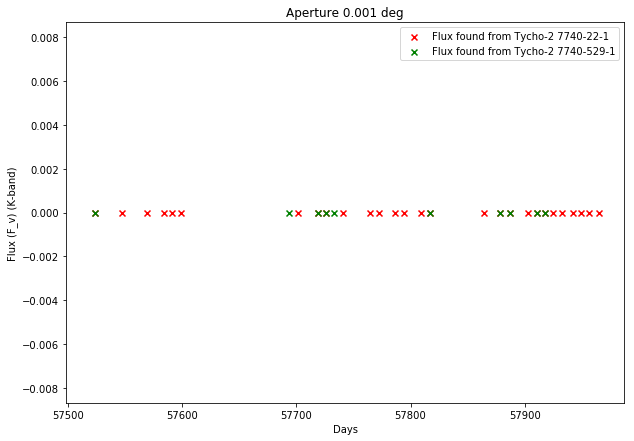

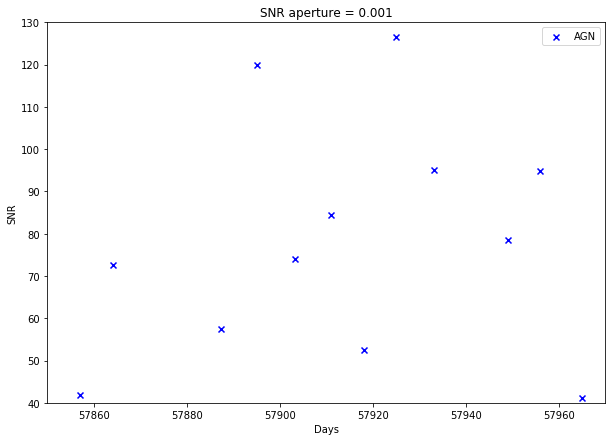

In [31]:

plt.figure(figsize=(10,7))
plt.scatter(date,np.array(ABS_FLUX_V_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date,np.array(ABS_FLUX_V_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_v) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([1*10**(-25),2*10**(-24)])
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
#plt.scatter(time,err)
plt.scatter(date,SNR1,marker='x',label='AGN',color='b')
#plt.scatter(date,poissonAGN,marker='o',label='Poisson AGN',color='b',alpha=0.4)
#plt.scatter(date,SNR2,marker='x',\
#            label='HD101274')
#plt.scatter(date,SNR2,marker='x',label='HD101274',color='black')
#plt.scatter(date,poissonHD,marker='o',label='Poisson HD101274',color='black',alpha=0.4)

#plt.scatter(date,SNR3,marker='x',label='Tycho-2 7740-22-1',color='r')
#plt.scatter(date,poisson22,marker='o',label='Poisson Tycho-2 7740-22-1',color='r',alpha=0.4)
#plt.scatter(date,SNR4,marker='x',label='Tycho-2 7740-529-1',color='g')
#plt.scatter(date,poisson529,marker='o',label='Poisson Tycho-2 7740-529-1',color='g',alpha=0.4)
#plt.scatter(date,np.array(SNR5),marker='x',\
#            label='Galaxy')
plt.xlabel('Days')
plt.ylabel('SNR')
plt.title('SNR aperture = 0.001')
plt.ylim([40,130])
plt.xlim([57850,57970])
plt.legend()
plt.show()

In [38]:
print quasJ
print flucompsta1

['/../home/lynge/MasterP/NGC3783/NGC3783J/0026-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0035-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0001-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0019-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0017-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0020-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0036-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0018-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0012-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0009-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0008-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0023-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0003-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0022-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0016-NGC3783J.fits', '/../home/lynge/MasterP/NGC3783/NGC3783J/0032-NGC3783J.fits', '/../ho

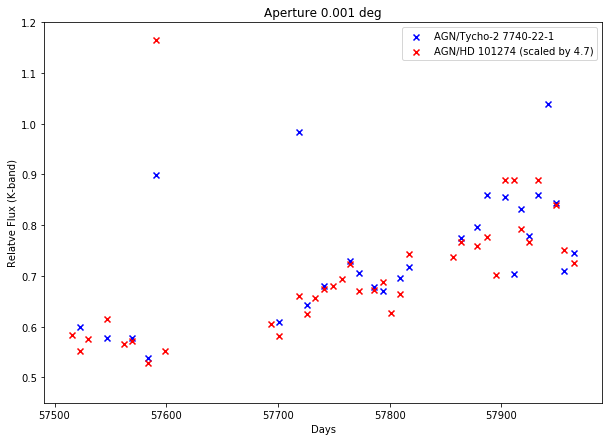

In [21]:

plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta2,marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,flucompsta1*5.8,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
#plt.scatter(date,flucompsta4*2.2,marker='x',\
#            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.ylim([0.45,1.2])
plt.legend()
plt.show()




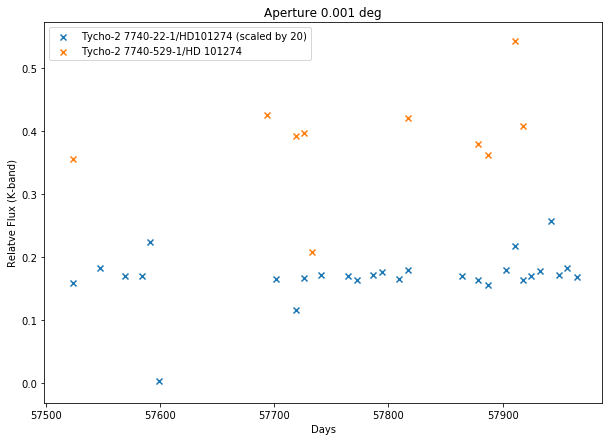

In [22]:

plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta3,marker='x',\
            label='Tycho-2 7740-22-1/HD101274 (scaled by 20)')
plt.scatter(date,flucompsta6,marker='x',\
            label='Tycho-2 7740-529-1/HD 101274')
#plt.scatter(date,np.array(flucompsta7),marker='x',\
#            label='Galaxy/HD 101274')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.legend()
plt.show()
